In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.models import resnet18
import numpy as np
from sklearn.svm import OneClassSVM
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
from PIL import Image
import random


# decide device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# fix random seed
SEED = 20
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# extra setting for cuda
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

Using device: cuda


In [ ]:
# data transform
transform_train= transforms.Compose([
    transforms.Resize((224, 224)), #resize from 32 32 to 224 224 for restnet input
    transforms.RandomHorizontalFlip(), # Random horizontal flip for data augmentation
    transforms.RandomCrop(224, padding=4), # Random crop of 224x224 with 4 pixels of padding
    transforms.ToTensor(), #change to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])    # Normalizes image using ImageNet mean and std
])
transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
# CIFAR-10 data loading
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)



100%|██████████| 170M/170M [00:03<00:00, 48.3MB/s]


In [ ]:
test_dataset


Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [ ]:
train_dataset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               RandomCrop(size=(224, 224), padding=4)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [ ]:
classes=train_dataset.classes
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [ ]:
normal_class_name = "airplane" # normal calss is airplane
normal_class_idx = classes.index(normal_class_name) #find index

print(f"Normal class name: {normal_class_name} (Index: {normal_class_idx})")



Normal class name: airplane (Index: 0)


In [ ]:
# creating a training dataset include only the normal class
train_normal_indices = [i for i, label in enumerate(train_dataset.targets) if label == normal_class_idx]
train_normal_dataset = torch.utils.data.Subset(train_dataset, train_normal_indices)

# set test data include both normal and anomaly class
test_normal_indices = [i for i, label in enumerate(test_dataset.targets) if label == normal_class_idx]
test_anomaly_indices = [i for i, label in enumerate(test_dataset.targets) if label != normal_class_idx]

# Relabel test samples  0 for normal, 1 for anomaly
test_data_normal = [test_dataset[i][0] for i in test_normal_indices]
test_labels_normal = [0] * len(test_data_normal) # 0 for normal

test_data_anomaly = [test_dataset[i][0] for i in test_anomaly_indices]
test_labels_anomaly = [1] * len(test_data_anomaly) # 1 for anomaly

test_images = test_data_normal + test_data_anomaly
test_labels = test_labels_normal + test_labels_anomaly

# DataLoader
train_loader = DataLoader(train_normal_dataset, batch_size=64, shuffle=True)


print(f"Number of normal training samples: {len(train_normal_dataset)}")



Number of normal training samples: 5000


In [ ]:

# load ResNet18 model pretrained
resnet_model = resnet18(pretrained=True)

# create simplified feature extractor
feature_extractor = nn.Sequential(
    resnet_model.conv1,
    resnet_model.bn1,
    resnet_model.relu,
    resnet_model.maxpool,
    resnet_model.layer1,
    resnet_model.layer2,
    resnet_model.layer3,
    # resnet_model.layer4,   # remove that layer
    nn.AdaptiveAvgPool2d((1, 1))
    # resnet_model.fc        Fully connected layer removed
)

#move it to device
feature_extractor.to(device)

# leave all layers trainable
for param in feature_extractor.parameters():
    param.requires_grad = True

# using a dummy input to find the output feature vector dimension
with torch.no_grad():
    dummy_input = torch.randn(1, 3, 224, 224).to(device)
    dummy_output = feature_extractor(dummy_input)
    output_dim_features = dummy_output.view(dummy_output.size(0), -1).shape[1]

print(f"output vector dimension: {output_dim_features}")



/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 141MB/s]


output vector dimension: 256


In [ ]:
def deep_svdd_loss(outputs, center):

    dist = torch.sum((outputs - center)**2, dim=1) #squared euclidean distance to center
    loss = torch.mean(dist)
    return loss

In [ ]:
def init_center(train_loader, model, output_dim, eps=1e-6):
    print("computing center...")
    n_samples = 0
    c = torch.zeros(output_dim, device=device) #initialize center
    model.eval() # set model to evaluation mode
    with torch.no_grad():  # disable gradient computation
        for data, _ in train_loader:
            data = data.to(device)
            features = model(data) # compute features from model
            features = features.view(features.size(0), -1) #flatten
            n_samples += features.size(0) #update sample num
            c += torch.sum(features, dim=0) #update accumulated c
    c /= n_samples
    # replace small values with epsilon to avoid numerical instability just for safety
    c[(abs(c) < eps) & (abs(c) != 0)] = eps
    print(f"initial center: {c[:3]}")
    return c

c = init_center(train_loader, feature_extractor, output_dim=output_dim_features)


computing center...
initial center: tensor([0.1592, 0.0184, 0.0888], device='cuda:0')


In [ ]:
def train_deep_svdd(train_loader, model, center, num_epochs=30, lr=0.0001, stop=5, min_delta=1e-4):
    model.train() # set model to training mode
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-6) #optimizer

    best_loss = float('inf')
    stop_counter = 0 #counter for early stop

    for epoch in range(num_epochs):
        total_loss = 0
        for data, _ in train_loader:
            data = data.to(device)
            optimizer.zero_grad() # reset gradients


            features = model(data) #compute features
            features = features.view(features.size(0), -1) #flatten

            loss = deep_svdd_loss(features, center) #compute loss
            loss.backward() # backpropagation
            optimizer.step() # update weights

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

        # early stopping condition
        if best_loss - avg_loss > min_delta:
            best_loss = avg_loss
            stop_counter = 0  # start from zero if there is  great improvment
        else:
            stop_counter += 1 # if there is no  great improvment increase counter
            print(f"stop: {stop_counter}/{stop}")
            if stop_counter >= stop:
                print("early stopping: train stopped.")
                break

    print("training completed")

train_deep_svdd(train_loader, feature_extractor, c, num_epochs=30)

Epoch [1/30], Loss: 0.5811
Epoch [2/30], Loss: 0.1315
Epoch [3/30], Loss: 0.0801
Epoch [4/30], Loss: 0.0552
Epoch [5/30], Loss: 0.0403
Epoch [6/30], Loss: 0.0299
Epoch [7/30], Loss: 0.0223
Epoch [8/30], Loss: 0.0167
Epoch [9/30], Loss: 0.0124
Epoch [10/30], Loss: 0.0091
Epoch [11/30], Loss: 0.0067
Epoch [12/30], Loss: 0.0049
Epoch [13/30], Loss: 0.0036
Epoch [14/30], Loss: 0.0026
Epoch [15/30], Loss: 0.0019
Epoch [16/30], Loss: 0.0014
Epoch [17/30], Loss: 0.0010
Epoch [18/30], Loss: 0.0007
Epoch [19/30], Loss: 0.0005
Epoch [20/30], Loss: 0.0004
Epoch [21/30], Loss: 0.0003
stop: 1/5
Epoch [22/30], Loss: 0.0003
Epoch [23/30], Loss: 0.0002
stop: 1/5
Epoch [24/30], Loss: 0.0002
stop: 2/5
Epoch [25/30], Loss: 0.0002
stop: 3/5
Epoch [26/30], Loss: 0.0001
Epoch [27/30], Loss: 0.0001
stop: 1/5
Epoch [28/30], Loss: 0.0001
stop: 2/5
Epoch [29/30], Loss: 0.0001
stop: 3/5
Epoch [30/30], Loss: 0.0001
stop: 4/5
training completed


In [ ]:
def evaluate_deep_svdd_manual(feature_extractor_model, center, test_images, test_labels, device):
    feature_extractor_model.eval()
    anomaly_scores = []
    true_labels = []

    with torch.no_grad(): # disable gradient computation
        for i in range(len(test_images)):
            img = test_images[i].unsqueeze(0).to(device)  #add batch value
            features = feature_extractor_model(img) #compute features
            features = torch.flatten(features, 1) #flatten
            score = torch.sum((features - center) ** 2, dim=1).item() # compute squared distance to center
            anomaly_scores.append(score) #store score
            true_labels.append(test_labels[i]) #store label

    return np.array(anomaly_scores), np.array(true_labels)


In [ ]:
scores, labels = evaluate_deep_svdd_manual(
    feature_extractor_model=feature_extractor,
    center=c,
    test_images=test_images,
    test_labels=test_labels,
    device=device
)

In [ ]:
deepsvdd_auc = roc_auc_score(labels, scores)
print(f"\nDeep SVDD AUC: {deepsvdd_auc:.4f}")

# for roc curve
fpr_deepsvdd, tpr_deepsvdd, thres = roc_curve(labels, scores) #false/true positive rates


Deep SVDD AUC: 0.7047


In [ ]:
j_scores = tpr_deepsvdd - fpr_deepsvdd
best_threshold = thres[np.argmax(j_scores)]
print(best_threshold)

8.826782141113654e-05


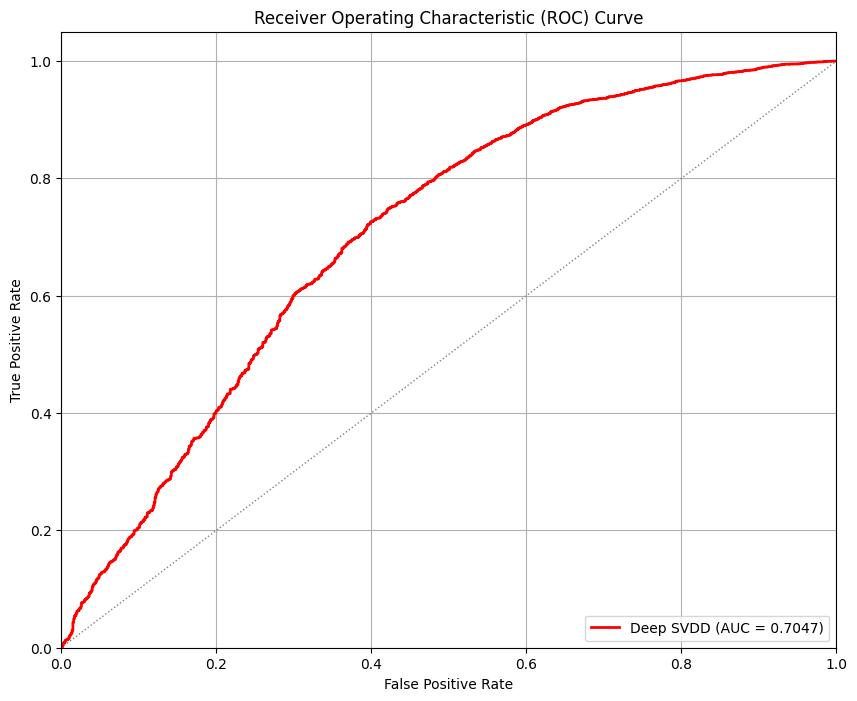

In [ ]:
plt.figure(figsize=(10, 8))
plt.plot(fpr_deepsvdd, tpr_deepsvdd, color='red', lw=2, label=f'Deep SVDD (AUC = {deepsvdd_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle=':')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [ ]:
#one class svm part

In [ ]:
transform_ocsvm = transforms.Compose([

    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [ ]:
train_dataset_ocsvm = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_ocsvm)
test_dataset_ocsvm = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_ocsvm)

In [ ]:
normal_class_name = "airplane"
classes = train_dataset_ocsvm.classes
normal_class_idx = classes.index(normal_class_name)

# set training data use only the normal class
train_normal_indices = [i for i, label in enumerate(train_dataset_ocsvm.targets) if label == normal_class_idx]
train_data_svm = [train_dataset_ocsvm[i][0].numpy().flatten() for i in train_normal_indices]
train_data_svm = np.stack(train_data_svm)

# set testing data include both normal and anomaly samples
test_normal_indices = [i for i, label in enumerate(test_dataset_ocsvm.targets) if label == normal_class_idx]
test_anomaly_indices = [i for i, label in enumerate(test_dataset_ocsvm.targets) if label != normal_class_idx]
#flatten
test_data_normal = [test_dataset_ocsvm[i][0].numpy().flatten() for i in test_normal_indices]
test_data_anomaly = [test_dataset_ocsvm[i][0].numpy().flatten() for i in test_anomaly_indices]
# concanate normal and anomaly data for testing
test_data_svm = np.stack(test_data_normal + test_data_anomaly)
test_labels = np.array([0] * len(test_data_normal) + [1] * len(test_data_anomaly))  # 0 = normal, 1 = anomaly

In [ ]:
ocsvm = OneClassSVM(kernel='rbf', gamma='scale', nu=0.1)  # create model
ocsvm.fit(train_data_svm) #train

OneClassSVM(nu=0.1)

In [ ]:
#first scores are higher for normal data and lower for anomalies
# we used - for compute metrics acccurately
scores = -ocsvm.decision_function(test_data_svm)
auc = roc_auc_score(test_labels, scores)

print(f"One-Class SVM ROC AUC: {auc:.4f}")

One-Class SVM ROC AUC: 0.6378
